# Introduction
The goal - Use different models to group claims by similar topics.</br>
In this notebook I will show various clustering models for the given task.</br>

Websites:
1. https://www.displayr.com/understanding-cluster-analysis-a-comprehensive-guide/
2. https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
3. https://medium.com/@sachinsoni600517/mastering-hierarchical-clustering-from-basic-to-advanced-5e770260bf93
4. https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95
5. https://vitalflux.com/find-topics-of-text-clustering-python-examples/
6. https://spotintelligence.com/2023/01/17/text-clustering-algorithms/

# Data Exploring

## 1. Data fetching and preprocessing
Load the pre-processed patent claims data as DataFrame and checking for any missing data values.</br>
Load the TF-IDF matrix as well.

In [1]:
import pandas as pd

# Load data
data_path = 'processed_patent_claims.csv'
df = pd.read_csv(data_path)


In [2]:
# Display first 5 rows
df.head()

,Patent URL,Normalized Claim
0,https://patents.google.com/patent/GB2478972A/e...,claim wireless telephone apparatus comprising ...
1,https://patents.google.com/patent/GB2478972A/e...,apparatus claim ftirther comprising body cradl...
2,https://patents.google.com/patent/GB2478972A/e...,apparatus claim ftirther comprising call recei...
3,https://patents.google.com/patent/GB2478972A/e...,apparatus claim wherein first predetermined bu...
4,https://patents.google.com/patent/GB2478972A/e...,apparatus claim wherein transfer mean toggle f...


In [3]:
df.shape

(61, 2)

In [4]:
# Check for missing values
missing_data = df['Normalized Claim'].isnull().sum()
print(f"Number of missing values in 'normalized_claims': {missing_data}")

Number of missing values in 'normalized_claims': 0


In [5]:
from scipy import sparse

matrix_path = 'tfidf_matrix.npz'
tfidf_matrix = sparse.load_npz(matrix_path)

# Show the shape of the matrix
print(tfidf_matrix.shape)


(61, 249)


## 2. Experiment Models

### 2.1 K-Means

In [6]:
# Import necessary libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
# Number of clusters
sse = []
n = 11

# Initialize and fit K-Means
for k in range (1, n):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)

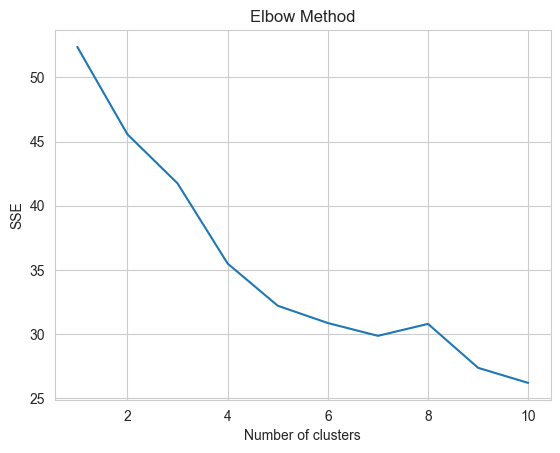

In [8]:
# Plotting (if dimensional reduction like PCA or t-SNE has been applied to reduce tfidf_matrix to 2D)
sns.set_style("whitegrid")
g = sns.lineplot(x=range(1, n), y=sse)

g.set(xlabel="Number of clusters", ylabel="SSE", title='Elbow Method')

plt.show()

Based on the graph above, using the elbow method, the optimal clusters are __6__.</br> I'll try to use clusters around this number to see what gives me the best result.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix

def cluster_and_visualize(tfidf_matrix: csr_matrix, k: int):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    # Retrieve the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    print(f"For {k} clusters, the average silhouette score is: {silhouette_avg}")
    
    # Reduce dimensions to 2D using PCA for visualization
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_matrix.toarray())
    centroids = kmeans.cluster_centers_
    reduced_centroids = pca.transform(centroids)
    
    # Create a color map
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    
    # Plotting
    plt.figure(figsize=(10, 8))
    for i, color in enumerate(colors):
        plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], 
                    color=color, label=f'Cluster {i}', alpha=1)

    # Plot centroids
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], marker='x', s=150, c='black', label='Centroids')
    plt.title(f'2D PCA of {k} Claim Clusters with Centroids')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='best')
    plt.show()



For 3 clusters, the average silhouette score is: 0.13833146741034769


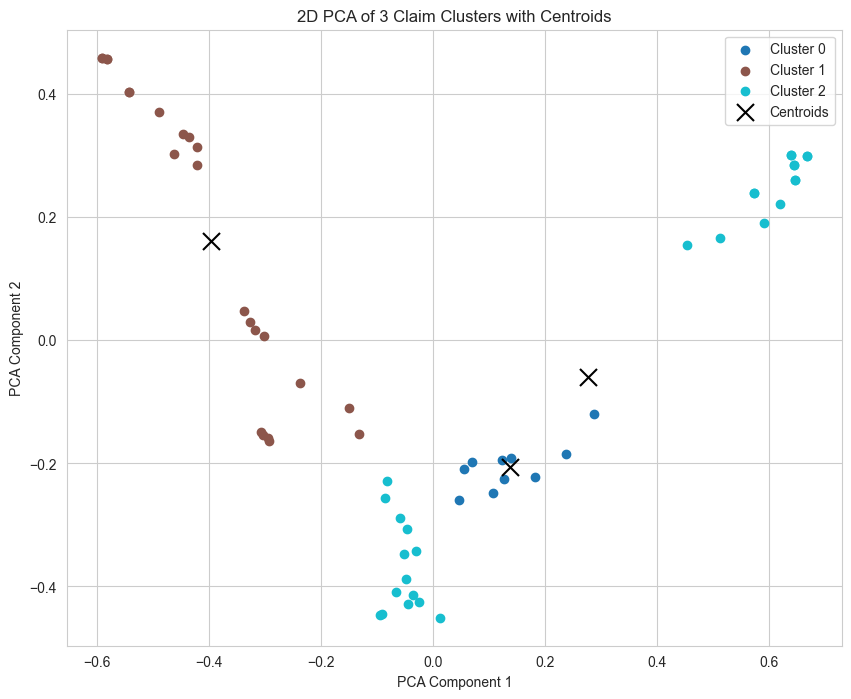

For 4 clusters, the average silhouette score is: 0.20201061760775252


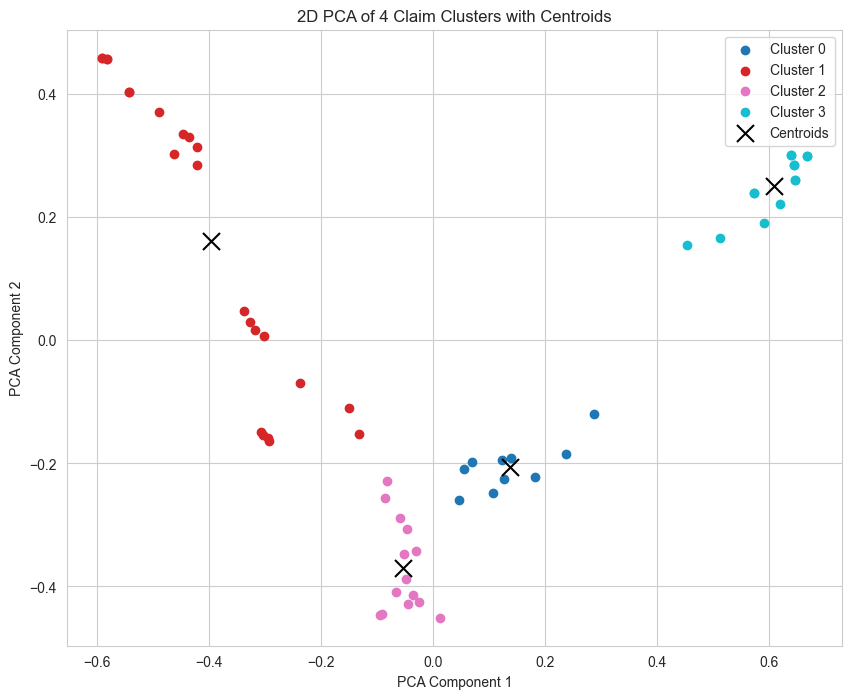

For 5 clusters, the average silhouette score is: 0.2244480287046338


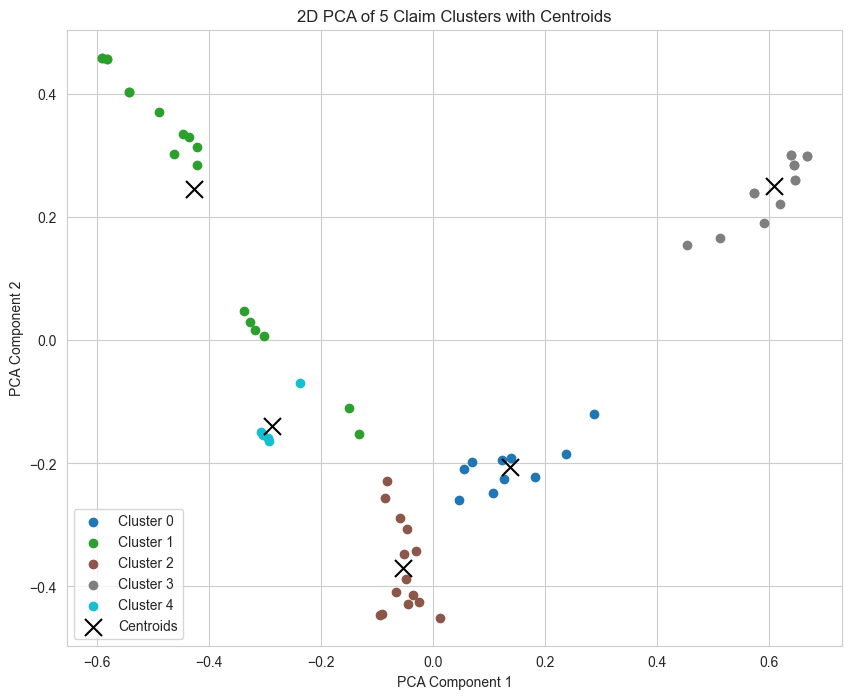

For 6 clusters, the average silhouette score is: 0.22490980905518235


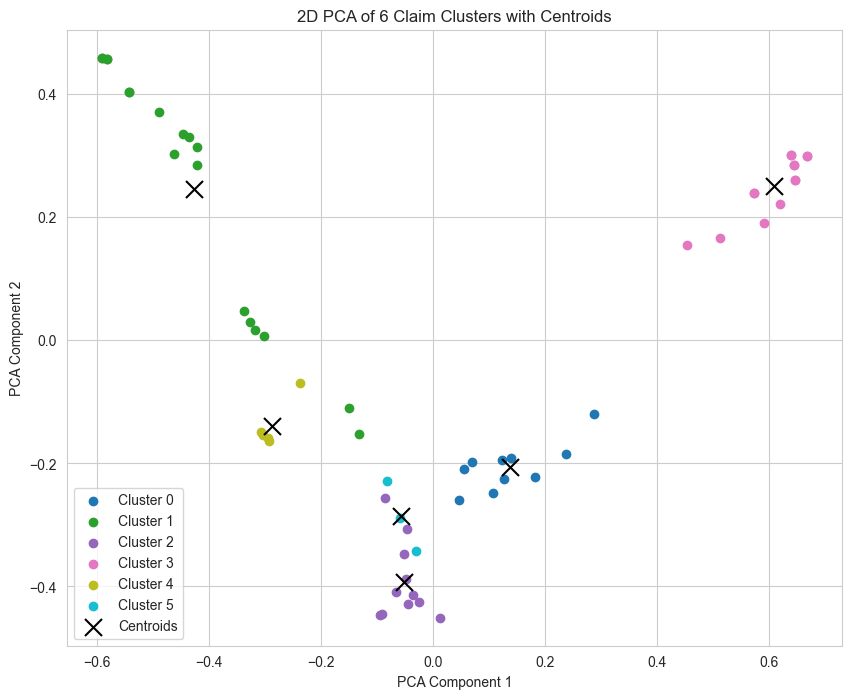

For 7 clusters, the average silhouette score is: 0.2140500588931559


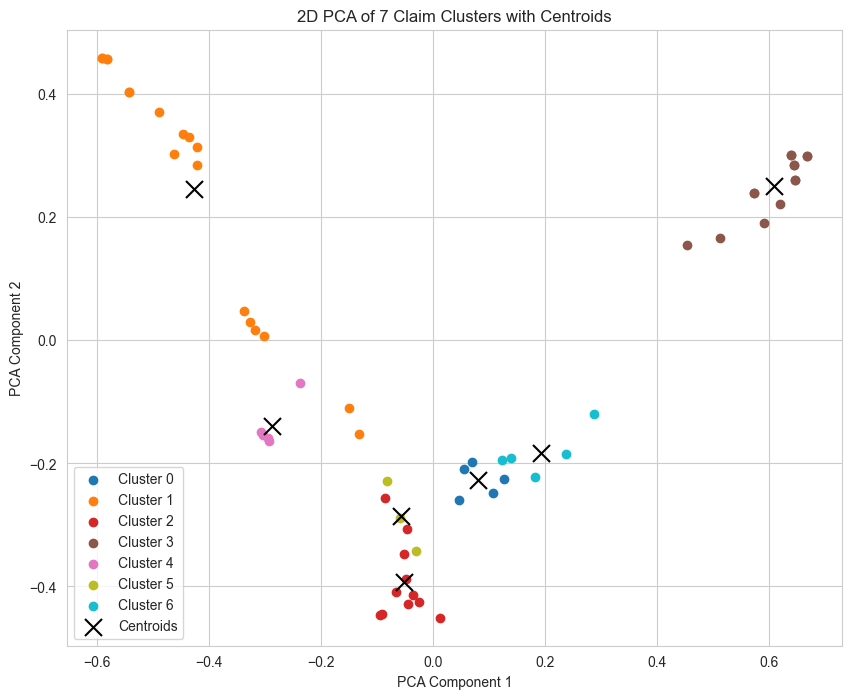

In [10]:
for i in range(3, 8):
    cluster_and_visualize(tfidf_matrix, k=i)

Based on these resulst, I'll use `k = 4`:</br>
1. The groups distribution is better</br>
2. The silhouette score is not so different from `k = 5, 6`

In [11]:
# Apply K-Means with K=4
k=4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

# Get cluster labels
cluster_labels = kmeans.labels_

# Load original data to attach labels
df = pd.read_csv('processed_patent_claims.csv')
df['Cluster Label'] = cluster_labels

# Save the DataFrame with cluster labels for further analysis
df.to_csv('claims_with_clusters.csv', index=False)

### Extracting Topics using LDA

Latent Dirichlet Allocation

In [12]:
# Group data by 'Cluster Label'
grouped = df.groupby('Cluster Label')['Normalized Claim'].apply(list)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to apply LDA to each cluster
def apply_lda_to_cluster(texts, n_topics=4, n_words=10):
    vectorizer = CountVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]{2,}\b')
    tf = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tf)
    
    # Display topics and collect the first word of each topic
    feature_names = vectorizer.get_feature_names_out()
    first_words = []  # List to store the first word of each topic
    for topic_idx, topic in enumerate(lda.components_):
        # Sort the topics and get the top words
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        
        # Append the first word of this topic to the list
        first_words.append(top_words[0] if top_words else None)
    
    # Return the list of first words for each topic
    return first_words


In [14]:
# Apply LDA to each cluster
for label, claims in grouped.items():
    kmeans_topics = apply_lda_to_cluster(claims)
    
print(kmeans_topics)

['predefined', 'said', 'measurement', 'measurement']


### 2.2 Hierarchical Clustering

In [15]:
# Import the necessary libraries
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.sparse import load_npz

In [16]:
# Load the TF-IDF matrix
tfidf_matrix = load_npz('tfidf_matrix.npz')

# Generate the linkage matrix using Ward's method
Z = linkage(tfidf_matrix.toarray(), method='ward')

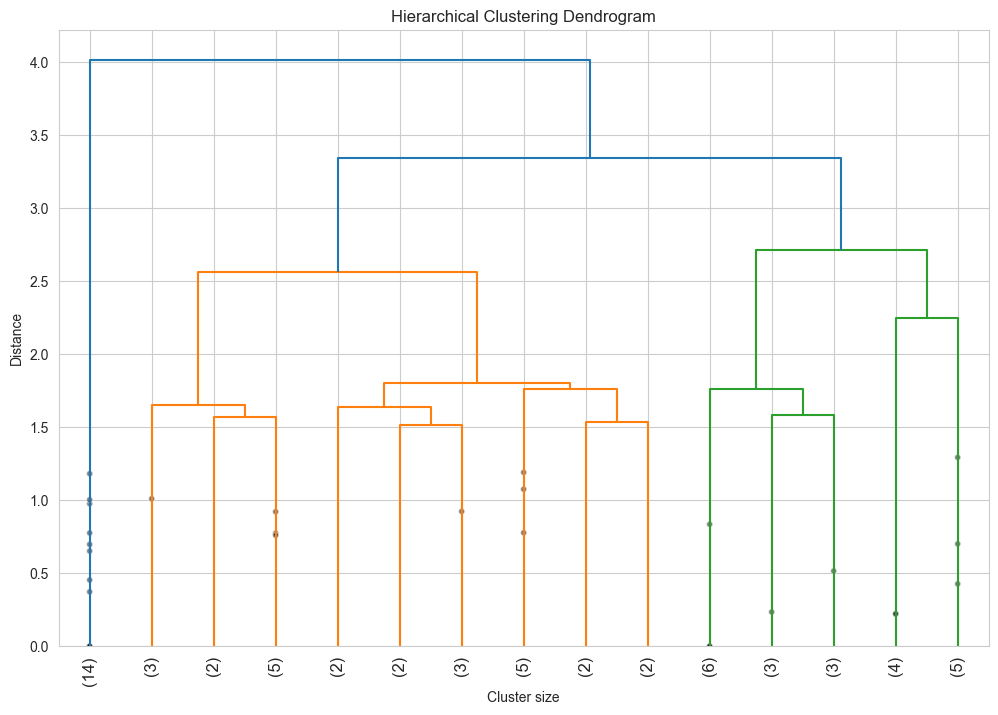

In [17]:
# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=15,  # show only the last 12 merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True  # to get a feel for the distribution inside the larger clusters
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

In [18]:
from scipy.cluster.hierarchy import fcluster

# Apply the fcluster function to cut the dendrogram at the determined number of clusters
cluster_labels = fcluster(Z, k, criterion='maxclust')

# Add cluster labels to your original dataframe
df['Cluster Label'] = cluster_labels

# Assuming 'Normalized Claim' is your column of processed texts
grouped_texts = df.groupby('Cluster Label')['Normalized Claim'].apply(list)


In [19]:
# Apply LDA to each cluster
for label, claims in grouped_texts.items():
    hierarchical_topics = apply_lda_to_cluster(claims)
    
print(hierarchical_topics)

['signal', 'obtaining', 'microphone', 'output']


### 2.3 GPT for Feature Extraction

In [20]:
# Import necessary libraries
from transformers import GPT2Model, GPT2Tokenizer
import torch
from sklearn.cluster import KMeans

# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

/opt/homebrew/Caskroom/miniforge/base/envs/moveoml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/moveoml/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
# Function to encode text and get embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of all token embeddings to get a single embedding vector per text
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [22]:

# Load the dataset from a CSV file
df = pd.read_csv('processed_patent_claims.csv')

# Assuming 'Normalized Claim' is the column with the text data
texts = df['Normalized Claim'].tolist()

In [23]:
from sklearn.cluster import KMeans

# Set the number of clusters
num_clusters = 3

# Generate embeddings for each text
embeddings = [get_embeddings(text) for text in texts]

# Clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(embeddings)
clusters = kmeans.labels_

# Add cluster labels back to the original DataFrame
df['Cluster Label'] = clusters

# Save the DataFrame with cluster labels if needed
df.to_csv('GPT_clustred_patent_claims.csv', index=False)

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def plot_clusters(embeddings, clusters):
    """
    Plots the results of K-means clustering using PCA for dimensionality reduction.
    
    Parameters:
    - embeddings: high-dimensional embeddings from GPT-2 or any other model.
    - clusters: cluster labels obtained from K-means.
    """
    # Calculate silhouette score
    sil_score = silhouette_score(embeddings, clusters)
    print(f"Silhouette Score: {sil_score:.2f}")
    
    reducer = PCA(n_components=2)
    title = 'K-means Clustering with 2D PCA'
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.8)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    
    # Create a legend
    # Get unique labels and colors from the plot
    unique_labels = list(set(clusters))
    unique_colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='', markersize=10) for color in unique_colors]
    plt.legend(markers, unique_labels, title="Clusters", borderpad=1)
    
    plt.show()


Silhouette Score: 0.27


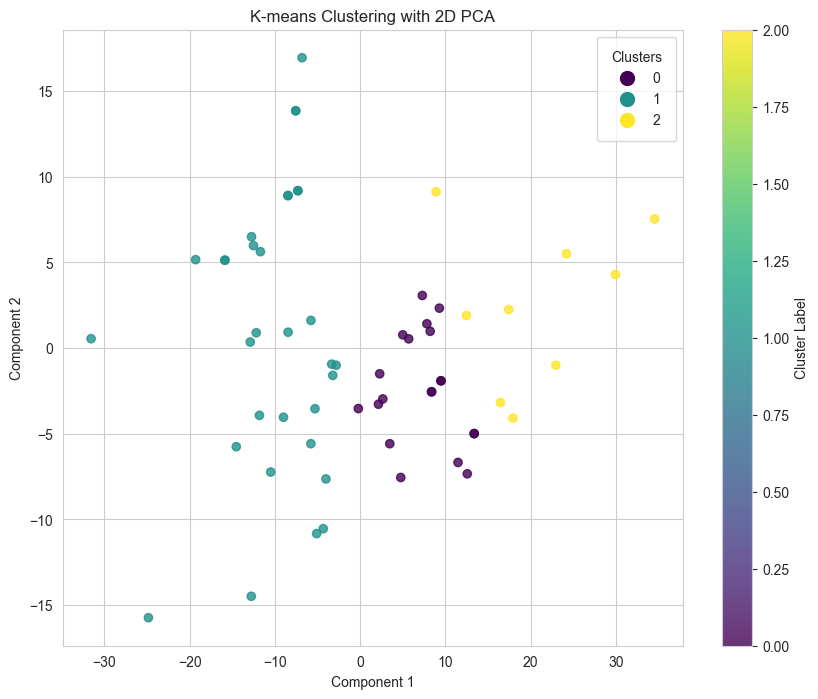

In [25]:
plot_clusters(embeddings, clusters)

In [26]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def display_top_terms(csv_file, n_terms=5):
    """
    Displays the top n_terms for each cluster from a CSV file containing clustered text data.
    
    Parameters:
    - csv_file: Path to the CSV file.
    - n_terms: Number of top terms to display for each cluster.
    """
    # Load the data
    df = pd.read_csv(csv_file)

    # Group the normalized claims by cluster label
    grouped = df.groupby('Cluster Label')['Normalized Claim']

    # Initialize a CountVectorizer
    vectorizer = CountVectorizer(stop_words='english')

    # Iterate over each cluster
    for cluster, claims in grouped:
        # Join all claims into a single text corpus
        corpus = " ".join(claims)
        # Vectorize the corpus
        X = vectorizer.fit_transform([corpus])
        # Get the feature names (words) and the corresponding counts
        words = vectorizer.get_feature_names_out()
        counts = X.toarray()[0]
        # Combine counts and words and sort by counts
        word_counts = sorted(zip(counts, words), reverse=True)[:n_terms]
        
        # Print the top words for the cluster
        print(f"\nCluster {cluster} top {n_terms} words:")
        for count, word in word_counts:
            print(f"{word} (count: {count})")

In [27]:
display_top_terms('GPT_clustred_patent_claims.csv')


Cluster 0 top 5 words:
output (count: 40)
signal (count: 38)
stimulus (count: 32)
representing (count: 27)
waveform (count: 26)

Cluster 1 top 5 words:
said (count: 90)
predefined (count: 62)
threshold (count: 60)
packet (count: 60)
loss (count: 60)

Cluster 2 top 5 words:
claim (count: 8)
distortion (count: 5)
button (count: 4)
said (count: 3)
method (count: 3)
